# Spatial analysis and simulations

**Load libraries (R and Python) and set up global variables**

In [145]:
library(reticulate)
library(sf)
library(gstat)
library(ggplot2)
library(repr)
library(GGally)
library(ggpubr)
library(sp)

In [146]:
# Load numpy to read numpy arrays
np <- import("numpy", convert=FALSE)

In [147]:
# set plot size in the notebook
options(repr.plot.width=4, repr.plot.height=3)

In [148]:
path_tmp <- "../data/tmp"

**Read in atom positions saved in numpy arrays and convert them into 'simple feature' datasets**

In [149]:
conc <- c('re05', 're55', 're78', 're95') # hdf5 file name roots

In [150]:
atoms <- list()
for (c in conc) {
    pos <- as.matrix(np$load(file.path(path_tmp, paste0(c, "_pos.npy"))))
    ids <- as.matrix(np$load(file.path(path_tmp, paste0(c, "_ids.npy"))))
    atoms[[c]] <- as.data.frame(cbind(pos, ids))
    names(atoms[[c]]) <- c("x", "y", "id")
}
atoms_sf <- lapply(atoms, st_as_sf, coords = c("x", "y"))

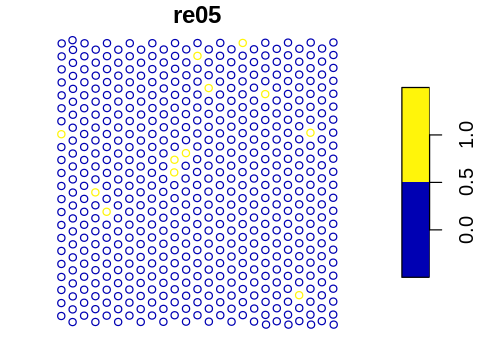

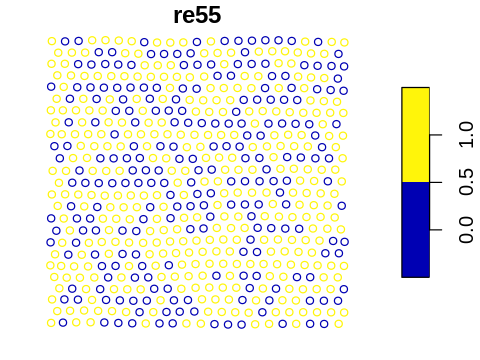

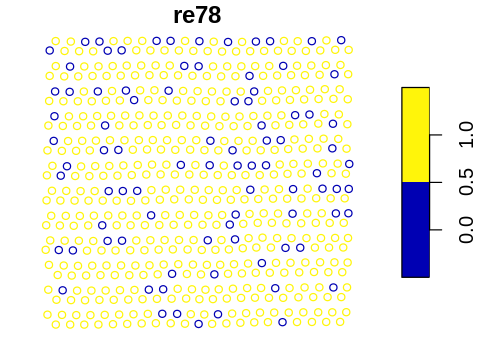

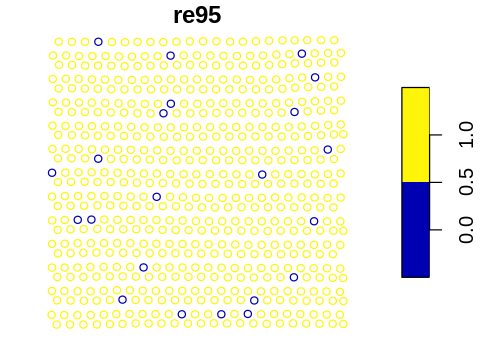

In [151]:
for (c in conc) {
    plot(atoms_sf[[c]], cex = 0.8, main= c)
}

**Calculate variograms**

In [189]:
vars <- list()
vars_fit <- list()
for (c in conc) {
  vars[[c]] <- variogram(I(id) ~ 1, atoms_sf[[c]], width = 4, cutoff = 80)
  vars_fit[[c]] <- fit.variogram(vars[[c]], vgm(NA, "Sph", NA))
}

Warning message in fit.variogram(vars[[c]], vgm(NA, "Sph", NA)):
“singular model in variogram fit”Warning message in fit.variogram(vars[[c]], vgm(NA, "Sph", NA)):
“No convergence after 200 iterations: try different initial values?”

In [190]:
# set plot size in the notebook
options(repr.plot.width=4, repr.plot.height=3)

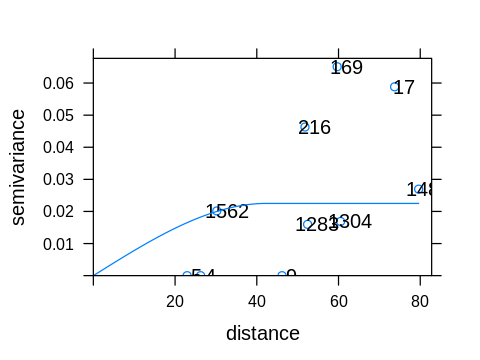

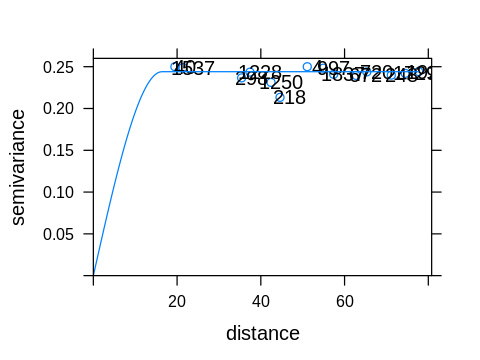

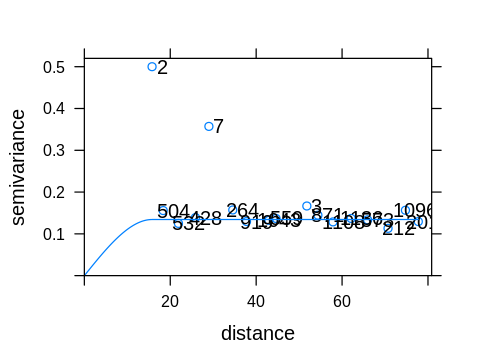

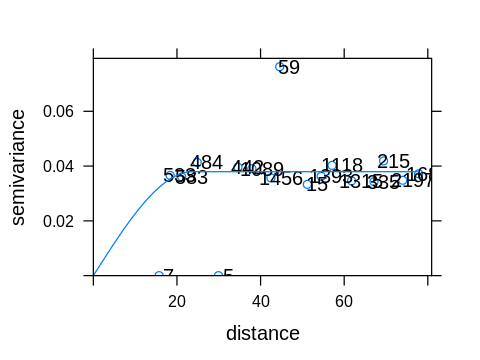

In [191]:
c = "re05"
plot(vars[[c]], vars_fit[[c]], plot.numbers = TRUE)
c = "re55"
plot(vars[[c]], vars_fit[[c]], plot.numbers = TRUE)
c = "re78"
plot(vars[[c]], vars_fit[[c]], plot.numbers = TRUE)
c = "re95"
plot(vars[[c]], vars_fit[[c]], plot.numbers = TRUE)

**Print variogram model parameters**

Only x_re == 0.05 indicates meaningful spatial dependence

In [192]:
lapply(vars_fit, print)

  model      psill    range
1   Sph 0.02250411 42.33468
  model     psill    range
1   Sph 0.2439981 16.38736
  model     psill    range
1   Sph 0.1343257 15.76508
  model      psill    range
1   Sph 0.03793978 23.70435


model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Sph,0.02250411,42.33468,0.5,0,0,0,1,1
model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Sph,0.2439981,16.38736,0.5,0,0,0,1,1
model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Sph,0.1343257,15.76508,0.5,0,0,0,1,1
model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Sph,0.03793978,23.70435,0.5,0,0,0,1,1


In [197]:
0.05*0.95
0.55*0.45
0.78*0.22
0.95*0.05

[1] 0.0475

[1] 0.2475

[1] 0.1716

[1] 0.0475

## Perform indicator simulations for each concetration

In [198]:
set.seed(42)
sim <- vector(mode = "list", length = length(atoms_sf))
names(sim) <- names(atoms_sf)
for (c in conc) {
    # Convert to sf to sp object
    dset_sp <- as(atoms_sf[[c]], "Spatial")
    # mean concentration
    beta <- as.numeric(substring(c, 3, 4))/100
    print(beta)
    # Perform indicator simulation
    sim[[c]] <- krige(I(id) ~ 1, locations = dset_sp, newdata = dset_sp, model = vars_fit[[c]],
                      indicators = TRUE, beta = beta, weights = rep(1/beta, nrow(atoms_sf[[c]])),
                      nsim = 100)
    sim[[c]] <- st_as_sf(sim[[c]])
}

[1] 0.05
[using conditional indicator simulation]
[1] 0.55
[using conditional indicator simulation]
[1] 0.78
[using conditional indicator simulation]
[1] 0.95
[using conditional indicator simulation]


In [199]:
options(repr.plot.width=5.5, repr.plot.height=5.5)

In [200]:
str(sim[["re05"]])

Classes ‘sf’ and 'data.frame':	555 obs. of  101 variables:
 $ sim1    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim2    : num  0 1 1 0 0 0 0 0 0 0 ...
 $ sim3    : num  0 0 0 0 0 0 0 0 0 1 ...
 $ sim4    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim5    : num  0 1 0 0 0 0 0 0 0 0 ...
 $ sim6    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim7    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim8    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim9    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim10   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim11   : num  0 0 0 0 0 0 0 0 0 1 ...
 $ sim12   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim13   : num  0 0 0 1 0 0 0 0 0 0 ...
 $ sim14   : num  1 0 0 0 0 0 0 0 0 0 ...
 $ sim15   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim16   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim17   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim18   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim19   : num  0 0 0 0 0 0 1 0 0 0 ...
 $ sim20   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim21   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim22   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sim23   : num 

## Plot simulated configurations

Warning message:
“plotting the first 9 out of 100 attributes; use max.plot = 100 to plot all”

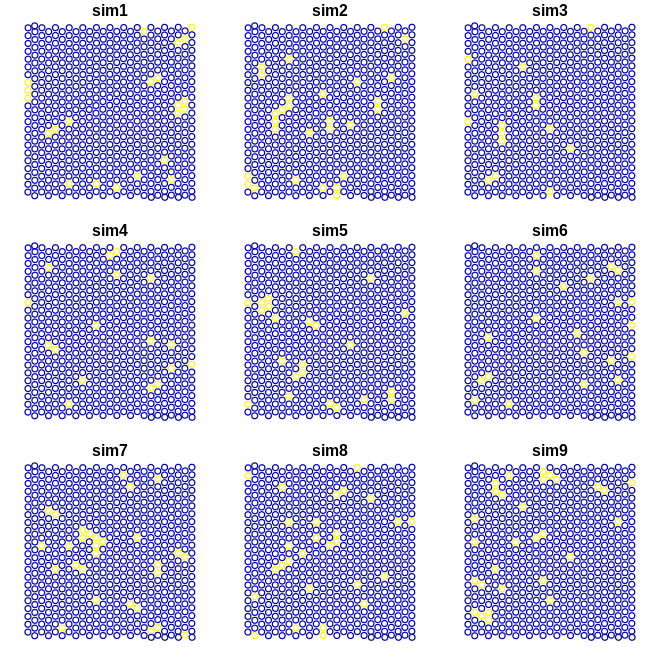

In [201]:
plot(sim[["re05"]])

Warning message:
“plotting the first 9 out of 100 attributes; use max.plot = 100 to plot all”

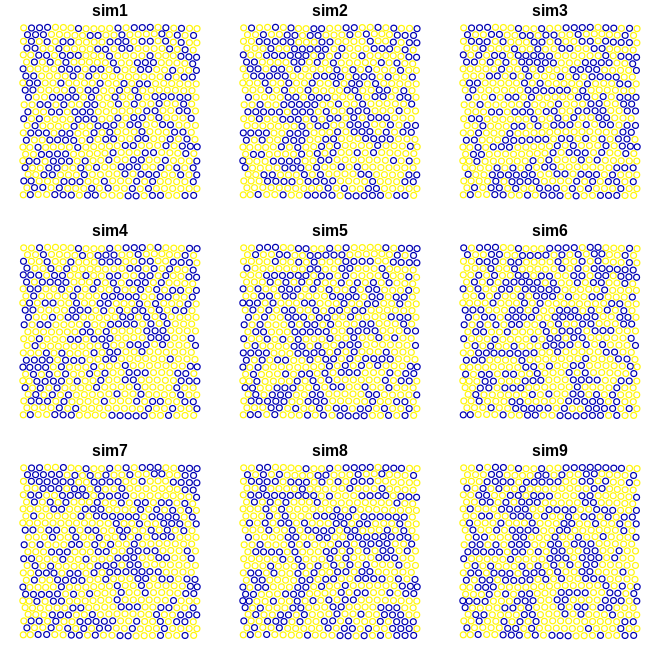

In [202]:
plot(sim[["re55"]])

Warning message:
“plotting the first 9 out of 100 attributes; use max.plot = 100 to plot all”

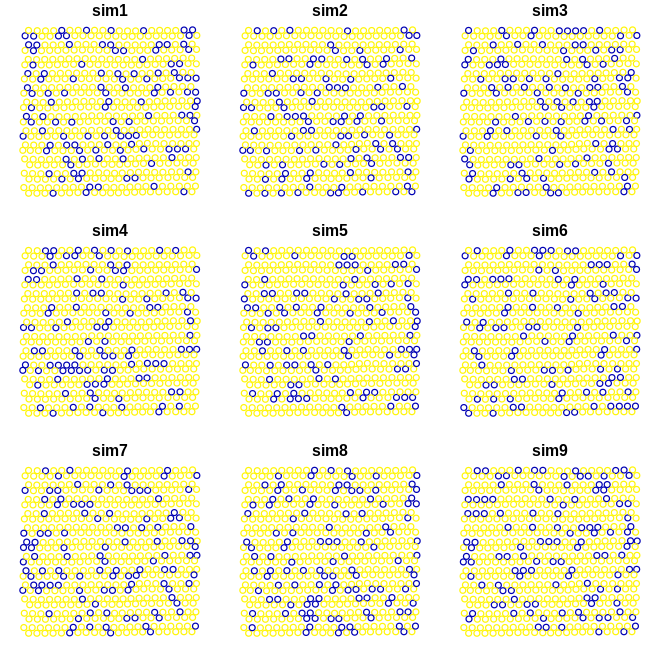

In [203]:
plot(sim[["re78"]])

Warning message:
“plotting the first 9 out of 100 attributes; use max.plot = 100 to plot all”

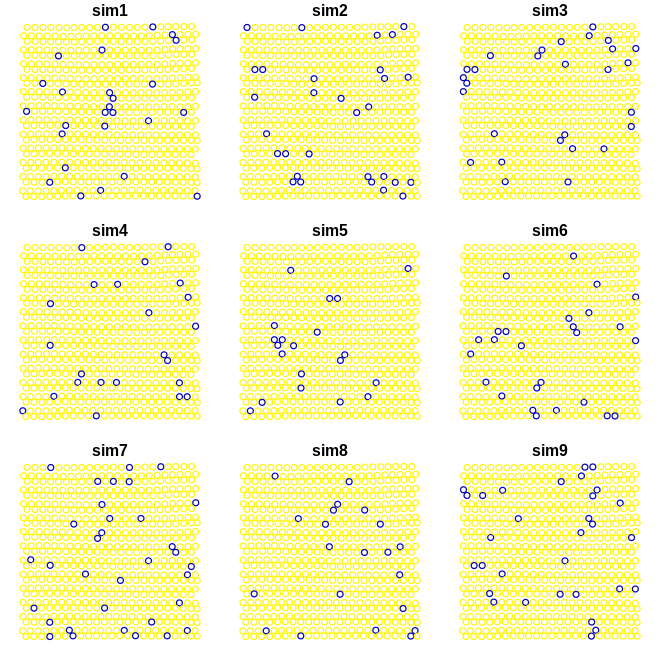

In [204]:
plot(sim[["re95"]])

## Save simulation results

In [206]:
for (c in conc) {
    mat <- cbind(st_drop_geometry(sim[[c]]), as.data.frame(st_coordinates(sim[[c]])))
    mat <- as.matrix(mat)
    np$save(file.path(path_tmp, paste0(c, "_sim2.npy")), mat)
}

In [207]:
dim(mat)

[1] 567 102